## Step 1: Load and Inspect the Dataset

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb 
import pandas as pd


In [82]:


# Load dataset
df = pd.read_csv('../data/personality_dataset.csv')

# Basic inspection
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (2900, 8)


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


## Step 2: Explore the Data (Column Types & Cleaning)


In [83]:
# Check for missing values and data types
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2900 non-null   float64
 1   Stage_fear                 2900 non-null   object 
 2   Social_event_attendance    2900 non-null   float64
 3   Going_outside              2900 non-null   float64
 4   Drained_after_socializing  2900 non-null   object 
 5   Friends_circle_size        2900 non-null   float64
 6   Post_frequency             2900 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [84]:
df.columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [85]:
df.dtypes

Time_spent_Alone             float64
Stage_fear                    object
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing     object
Friends_circle_size          float64
Post_frequency               float64
Personality                   object
dtype: object

In [86]:
df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2900.000000,2900.000000,2900.000000,2900.000000,2900.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.441180,2.872608,2.221597,4.232340,2.893587
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.963354,3.000000,5.000000,3.000000
75%,7.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [87]:
print("Unique values in 'Stage_fear':")
print(df['Stage_fear'].unique())

print("\nUnique values in 'Drained_after_socializing':")
print(df['Drained_after_socializing'].unique())

print("\nValue counts for 'Personality':")
print(df['Personality'].value_counts())

# Data looks clean right from the beginning... sus

Unique values in 'Stage_fear':
['No' 'Yes']

Unique values in 'Drained_after_socializing':
['No' 'Yes']

Value counts for 'Personality':
Personality
Extrovert    1491
Introvert    1409
Name: count, dtype: int64


In [88]:
# Create helper columns for plotting with labels
df['Personality_label'] = df['Personality']
df['Stage_fear_label'] = df['Stage_fear']
df['Drained_after_socializing_label'] = df['Drained_after_socializing'] 

# Map Yes/No to 1/0
df['Stage_fear'] = df['Stage_fear'].map({'Yes': 1, 'No': 0})
df['Drained_after_socializing'] = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0})

# Map Personality to 1/0
df['Personality'] = df['Personality'].map({'Extrovert': 1, 'Introvert': 0})

# Confirm the changes
df.head()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Personality_label,Stage_fear_label,Drained_after_socializing_label
0,4.0,0,4.0,6.0,0,13.0,5.0,1,Extrovert,No,No
1,9.0,1,0.0,0.0,1,0.0,3.0,0,Introvert,Yes,Yes
2,9.0,1,1.0,2.0,1,5.0,2.0,0,Introvert,Yes,Yes
3,0.0,0,6.0,7.0,0,14.0,8.0,1,Extrovert,No,No
4,3.0,0,9.0,4.0,0,8.0,5.0,1,Extrovert,No,No


## Step 3: Exploratory Data Analysis (EDA) & Visualization


Goal: Understand how the features differ between introverts and extroverts visually.

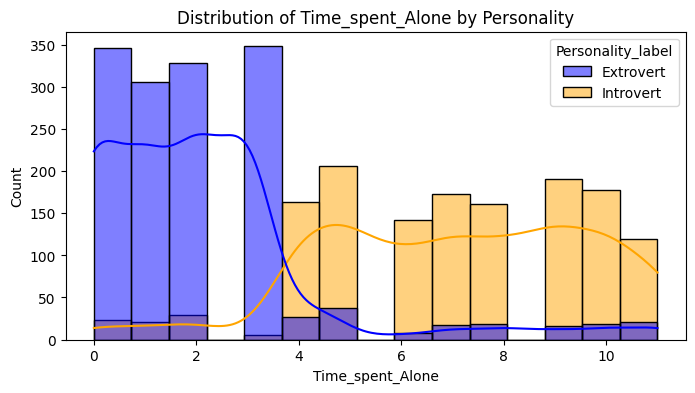

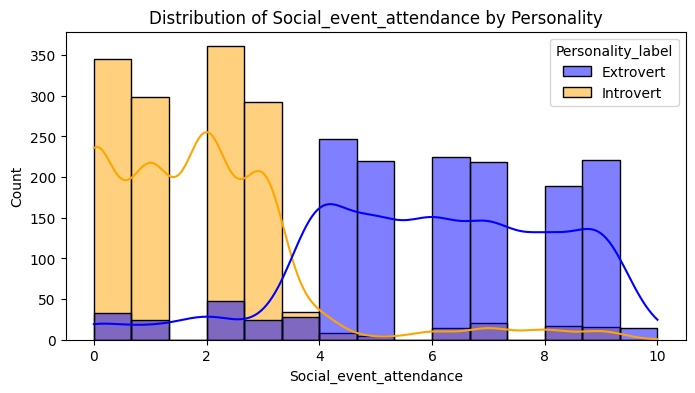

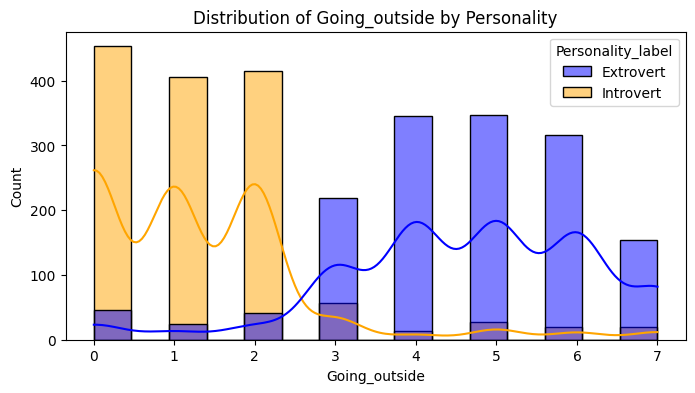

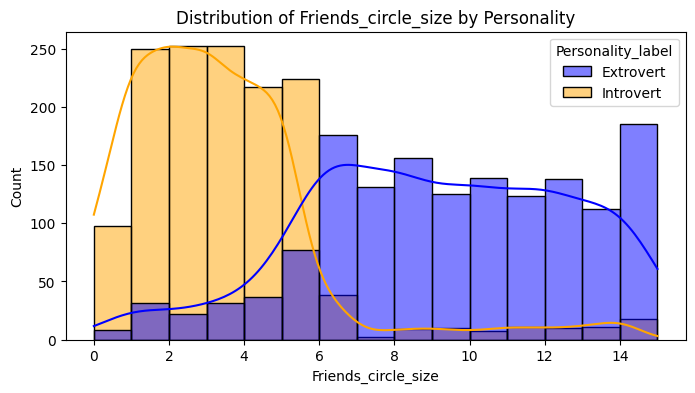

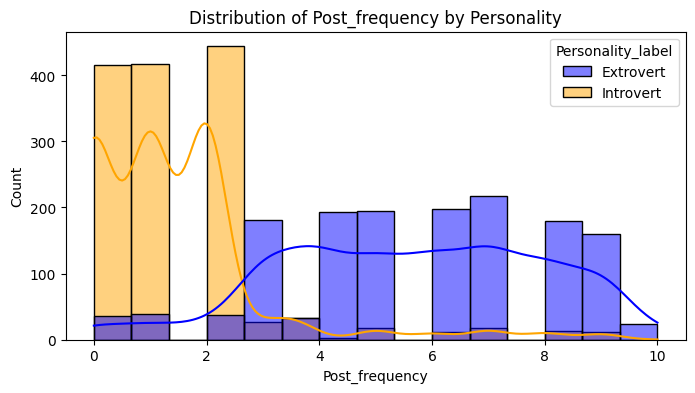

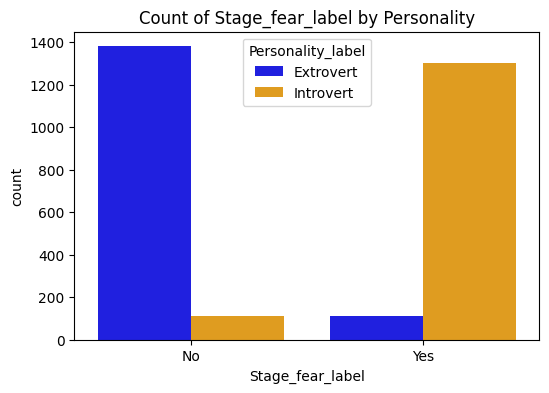

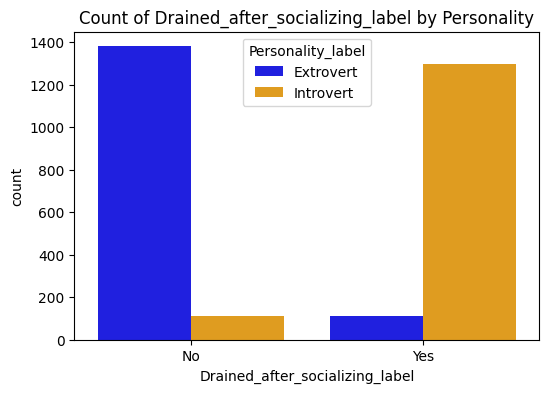

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numeric features
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                    'Friends_circle_size', 'Post_frequency']

# Plot histograms
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=feature, hue='Personality_label', bins=15, kde=True, palette=['blue', 'orange'])
    plt.title(f'Distribution of {feature} by Personality')
    plt.show()

# Plot count plots for binary features
binary_features = ['Stage_fear_label', 'Drained_after_socializing_label']

for feature in binary_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=feature, hue='Personality_label', palette=['blue', 'orange'])
    plt.title(f'Count of {feature} by Personality')
    plt.show()


## Step 4: Prepare Data for Modeling (Split & Scale)

Tasks:
* Split the data into features (X) and target (y).
* Train-test split: Reserve some data for testing the model after training.
* Scale numeric features.

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop helper columns used for plotting
df = df.drop(columns=['Personality_label', 'Stage_fear_label', 'Drained_after_socializing_label'])

# Define X and y
X = df.drop(columns=['Personality'])
y = df['Personality']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                    'Friends_circle_size', 'Post_frequency']

scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Shapes after split:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Shapes after split:
X_train: (2320, 7)
X_test: (580, 7)
y_train: (2320,)
y_test: (580,)


## 🧪 Step 5: Train and Compare Multiple Models

Goal: Train a few different models and compare their accuracy side-by-side.
1. Logistic Regression 
2. K-Nearest Neighbors (KNN)
3. Support Vector Machine (SVM)
4. Random Forest
5. XGBoost (optional, if installed)

#### 📊 Create a function to train and evaluate

In [91]:
# Helper function to train and evaluate
def evaluate_model(name, model, X_train, X_test, y_train, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    results.append((name, acc))

#### 🚀 Train the models:

In [92]:
results = []

# Logistic Regression (again, for comparison)
evaluate_model("Logistic Regression", LogisticRegression(), X_train, X_test, y_train, y_test, results)

# K-Nearest Neighbors
evaluate_model("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test, results)

# Support Vector Machine
evaluate_model("SVM", SVC(kernel='linear'), X_train, X_test, y_train, y_test, results)

# Random Forest
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, results)

# XGBoost (optional)
# Comment this out if xgboost is not installed
evaluate_model("XGBoost", xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X_train, X_test, y_train, y_test, results)


Logistic Regression Accuracy: 0.9172
K-Nearest Neighbors Accuracy: 0.9190
SVM Accuracy: 0.9172
Random Forest Accuracy: 0.9086
XGBoost Accuracy: 0.9103


c:\Users\zales\Documents\workspace\data science projects\behavior-based-personality-prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:46:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### 📈 Plot the results:

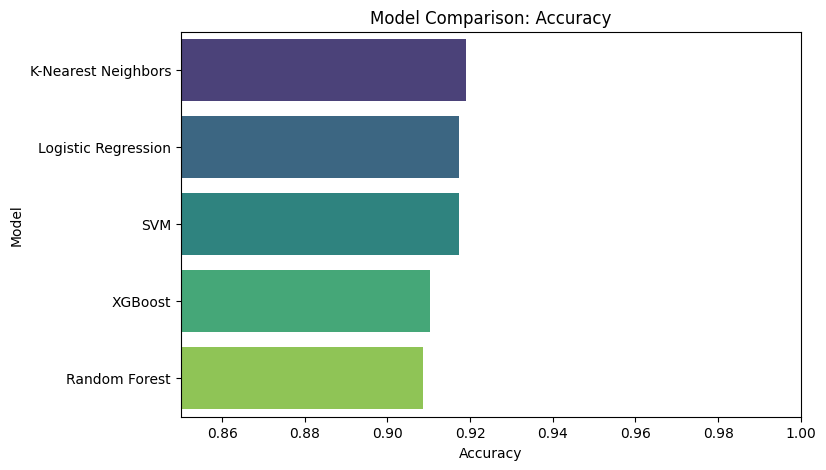

,Model,Accuracy
1,K-Nearest Neighbors,0.918966
0,Logistic Regression,0.917241
2,SVM,0.917241
4,XGBoost,0.910345
3,Random Forest,0.908621


In [97]:
# Turn into DataFrame for comparison
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Accuracy", y="Model", palette="viridis", hue="Model", legend=False)
plt.title("Model Comparison: Accuracy")
plt.xlim(0.85, 1.00)
plt.show()

results_df